In [31]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from typing import Union
import os
from datetime import datetime
from datetime import date

tqdm.pandas()

In [32]:
DATA_CSV_PATH = 'dataset.csv'

# Add info
CRYTICAL_TASK_ID_LIST = [
    '1', '1.4.2', '3', '3.1', '3.3', '3.8', '3.11', '3.13',
    '3.15', '4', '4.1.1', '4.2', '4.3', '4.4', '4.5', '4.6', 
    '4.7', '4.8', '4.9', '4.10', '4.11', '4.12', '5', '5.11', 
    '7.1', '7.1.8', '7.4', '8'
]
CRITICAL_TASK_MAP = {
    '1': 'Предпроектные работы',
    '1.4.2': 'Заключение ДАЗУ на период строительства',
    '3': 'Проектно-изыскательские работы',
    '3.1': 'Задание на проектирование',
    '3.3': 'Разработка и согласование АПР',
    '3.8': 'Утверждение перечня ТХ в ДОНМ',
    '3.11': 'Разработка проектно-сметной документации (Стадия П)',
    '3.13': 'Экспертиза проекта',
    '3.15': 'Разработка Рабочей документации',
    '4': 'Строительно-монтажные работы',
    '4.1.1': 'Разрешение на строительство',
    '4.2': 'Подготовительные работы',
    '4.3': 'Земляные работы (котлован)',
    '4.4': 'Монолитные работы',
    '4.5': 'Кровля',
    '4.6': 'Устройство фасадов и остекление (закрытие контутра)',
    '4.7': 'Внутренние инженерные системы',
    '4.8': 'Технологическое оборудование',
    '4.9': 'Отделочные работы',
    '4.10': 'ПНР',
    '4.11': 'Наружные инженерные сети',
    '4.12': 'Благоустройство',
    '5': 'Завершение строительства и приемка работ',
    '5.11': 'Комплексные испытания',
    '7.1': 'Проведение итоговой проверки МГСН',
    '7.1.8': 'Получение Заключения о соответствии',
    '7.4': 'Разрешение на ввод в эксплуатацию',
    '8': 'Передача объекта на баланс эксплуатирующей организации'
}

DROP_COLUMNS_WITH_NAN = ['Кодзадачи','ПроцентЗавершенияЗадачи','ДатаНачалаЗадачи','ДатаОкончанияЗадачи']
DROP_COLUMNS = ['date_report','Статуспоэкспертизе', 'Экспертиза','НазваниеЗадачи',
                '№ п/п','obj_subprg'] # TO DO: доделать по организациям

In [33]:
# Support func

def sort_key(item):
    parts = str(item).split('.')
    return [int(part) for part in parts]

#items = list(df['Кодзадачи'].unique())
#sorted_items = sorted(items, key=sort_key)

def str_to_date(date_str: Union[str, None]) -> Union[date, None]:
    ''' 
    input data format: %Y-%m-%d
    '''
    if isinstance(date_str, str):
        return datetime.strptime(date_str, '%Y-%m-%d').date()
    else:
        return None
    
def calc_dif_date(date1: date, date2: date) -> date:
    ''' 
    calculate difference between two dates
    '''
    if isinstance(date1, date) and isinstance(date2, date):
        return (date2-date1).days
    else:
        return None
    
def group_task(item):
    parts = str(item).split('.')
    return '.'.join(parts[:2])

In [34]:
df = pd.read_csv(os.path.join('data', DATA_CSV_PATH), on_bad_lines='skip', sep=';', index_col=0)
df = df.dropna(subset=DROP_COLUMNS_WITH_NAN)
df = df.drop(DROP_COLUMNS, axis=1)
df

,obj_prg,obj_key,Кодзадачи,ПроцентЗавершенияЗадачи,ДатаНачалаЗадачи,ДатаОкончанияЗадачи,ДатаначалаБП0,ДатаокончанияБП0
0,Образование,022-0527,1,0.0,2022-01-14,2023-03-30,NaN,NaN
1,Образование,022-0354,1,0.0,2022-12-01,2023-07-27,NaN,NaN
2,Образование,019-0594,1,0.0,2021-05-04,2021-12-15,2021-05-04,2021-12-15
3,Образование,019-0431,1,100.0,2020-11-02,2021-07-26,2020-11-02,2021-07-26
4,Образование,019-0676,1,100.0,2021-02-01,2022-09-15,2021-02-01,2022-07-31
...,...,...,...,...,...,...,...,...
63491,Образование,022-0522,9.6.2,0.0,2025-08-11,2025-08-11,2025-08-11,2025-08-11
63492,Образование,022-0527,9.6.2,0.0,2024-08-21,2024-08-21,2024-08-07,2024-08-07
63493,Образование,022-0526,9.6.2,0.0,2025-08-11,2025-08-11,2025-08-11,2025-08-11
63494,Образование,022-0354,9.6.2,0.0,2025-07-21,2025-07-21,2025-07-21,2025-07-21


In [35]:
DATE_COLUMNS = ['ДатаНачалаЗадачи','ДатаОкончанияЗадачи',
                'ДатаначалаБП0', 'ДатаокончанияБП0']

# препроцессинг данных
for i, column in enumerate(DATE_COLUMNS):
    df[column] = df[column].apply(str_to_date)
    
# Добавляем время работ
df['ПлановоеВремяРаботы'] = df[['ДатаНачалаЗадачи', 
                                'ДатаОкончанияЗадачи']].progress_apply(lambda x: calc_dif_date(*x), axis=1)
df['БП0ВремяРаботы'] = df[['ДатаначалаБП0', 
                                'ДатаокончанияБП0']].progress_apply(lambda x: calc_dif_date(*x), axis=1)

# Добавляем перегрупировку тасок
df['NewКодзадачи'] = df['Кодзадачи'].progress_apply(group_task)

# Добавляем календарные фичи
df['НаСколькоПозжеНачали'] = df[['ДатаначалаБП0', 
                                'ДатаНачалаЗадачи']].progress_apply(lambda x: calc_dif_date(*x), axis=1)
df = df.astype({'ПлановоеВремяРаботы': 'Int64', 'БП0ВремяРаботы': 'Int64', 'НаСколькоПозжеНачали': 'Int64'})

# Таргет (на сколько задержимся)
df['НаСколькоЗадержались'] = df[['ДатаокончанияБП0', 
                                'ДатаОкончанияЗадачи']].progress_apply(lambda x: calc_dif_date(*x), axis=1)
df = df.astype({'ПлановоеВремяРаботы': 'Int64', 'БП0ВремяРаботы': 'Int64',
                'НаСколькоПозжеНачали': 'Int64', 'НаСколькоЗадержались': 'Int64'})

100%|█████████████████████████████| 1506891/1506891 [00:03<00:00, 485231.26it/s]


In [36]:
df

,obj_prg,obj_key,Кодзадачи,ПроцентЗавершенияЗадачи,ДатаНачалаЗадачи,ДатаОкончанияЗадачи,ДатаначалаБП0,ДатаокончанияБП0,ПлановоеВремяРаботы,БП0ВремяРаботы,NewКодзадачи,НаСколькоПозжеНачали,НаСколькоЗадержались
0,Образование,022-0527,1,0.0,2022-01-14,2023-03-30,None,None,440,<NA>,1,<NA>,<NA>
1,Образование,022-0354,1,0.0,2022-12-01,2023-07-27,None,None,238,<NA>,1,<NA>,<NA>
2,Образование,019-0594,1,0.0,2021-05-04,2021-12-15,2021-05-04,2021-12-15,225,225,1,0,0
3,Образование,019-0431,1,100.0,2020-11-02,2021-07-26,2020-11-02,2021-07-26,266,266,1,0,0
4,Образование,019-0676,1,100.0,2021-02-01,2022-09-15,2021-02-01,2022-07-31,591,545,1,0,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63491,Образование,022-0522,9.6.2,0.0,2025-08-11,2025-08-11,2025-08-11,2025-08-11,0,0,9.6,0,0
63492,Образование,022-0527,9.6.2,0.0,2024-08-21,2024-08-21,2024-08-07,2024-08-07,0,0,9.6,14,14
63493,Образование,022-0526,9.6.2,0.0,2025-08-11,2025-08-11,2025-08-11,2025-08-11,0,0,9.6,0,0
63494,Образование,022-0354,9.6.2,0.0,2025-07-21,2025-07-21,2025-07-21,2025-07-21,0,0,9.6,0,0


In [37]:
# Анализ датасета
print('Инфа по датасету')
print(df.info(), end='\n'*2)

print(f'Размер датасета: {len(df)}', end='\n'*2)

print('Инфа по пропущенным значениям')
print(df.isna().sum(), end='\n'*2)

print('Колличество обьектов')
print(len(list(df['obj_key'].unique())), end='\n'*2)

print('Описание данных')
print(df.describe(), end='\n'*2)

Инфа по датасету
<class 'pandas.core.frame.DataFrame'>
Index: 1506891 entries, 0 to 63495
Data columns (total 13 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   obj_prg                  1506891 non-null  object 
 1   obj_key                  1506891 non-null  object 
 2   Кодзадачи                1506891 non-null  object 
 3   ПроцентЗавершенияЗадачи  1506891 non-null  float64
 4   ДатаНачалаЗадачи         1506891 non-null  object 
 5   ДатаОкончанияЗадачи      1506891 non-null  object 
 6   ДатаначалаБП0            1104180 non-null  object 
 7   ДатаокончанияБП0         1110697 non-null  object 
 8   ПлановоеВремяРаботы      1506891 non-null  Int64  
 9   БП0ВремяРаботы           1104113 non-null  Int64  
 10  NewКодзадачи             1506891 non-null  object 
 11  НаСколькоПозжеНачали     1104180 non-null  Int64  
 12  НаСколькоЗадержались     1110697 non-null  Int64  
dtypes: Int64(4), float64(1), object(

In [38]:
COLUMNS_DROP_NAN = ['НаСколькоПозжеНачали', 'НаСколькоЗадержались']
df = df.dropna(subset=COLUMNS_DROP_NAN)
df = df.loc[:, ['NewКодзадачи', 'НаСколькоПозжеНачали','НаСколькоЗадержались', 'obj_prg']]
df.columns = ['task_id', 'late_start', 'target', 'obj_prg']
df['id'] = range(1, len(df)+1)
df

,task_id,late_start,target,obj_prg,id
2,1,0,0,Образование,1
3,1,0,0,Образование,2
4,1,0,46,Образование,3
5,1,0,-133,Образование,4
6,1,0,389,Образование,5
...,...,...,...,...,...
63490,9.6,0,0,Образование,1104109
63491,9.6,0,0,Образование,1104110
63492,9.6,14,14,Образование,1104111
63493,9.6,0,0,Образование,1104112


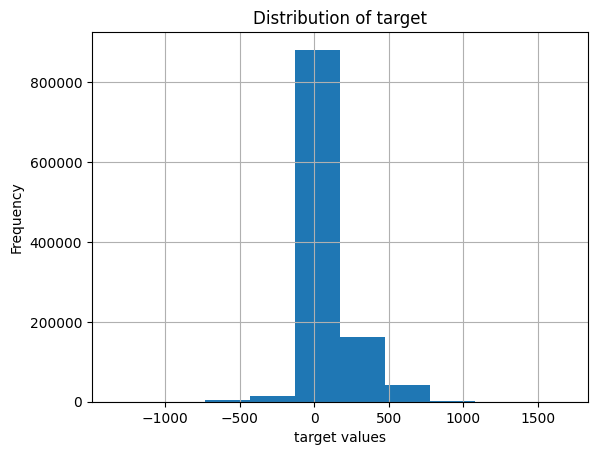

In [39]:
import matplotlib.pyplot as plt
# строим график распределения для колонки 'col1'
df['target'].hist()

# добавляем заголовок и подписи к осям
plt.title('Distribution of target')
plt.xlabel('target values')
plt.ylabel('Frequency')

# выводим график
plt.show()

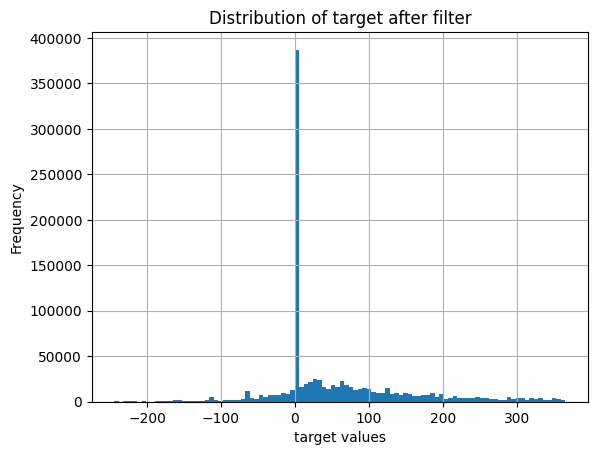

In [40]:
# вычисляем квартили и межквартильный размах
Q1 = df['target'].quantile(0.25)
Q3 = df['target'].quantile(0.75)
IQR = Q3 - Q1

# определяем границы интервала без выбросов
lower_bound = Q1 - 2*IQR
upper_bound = Q3 + 2*IQR

# удаляем строки, содержащие выбросы
df = df.loc[(df['target'] >= lower_bound) & (df['target'] <= upper_bound)]

import matplotlib.pyplot as plt
# строим график распределения для колонки 'col1'
df['target'].hist(bins=100)

# добавляем заголовок и подписи к осям
plt.title('Distribution of target after filter')
plt.xlabel('target values')
plt.ylabel('Frequency')

# выводим график
plt.show()

# Train

In [41]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor, cv, Pool

from collections import defaultdict

from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

import shap
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline

from tqdm import tqdm

In [43]:
train, test = train_test_split(df, test_size=0.33, random_state=42)
train.head()

,task_id,late_start,target,obj_prg,id
26793,3.5,185,179,Образование,602994
62593,9.3,0,0,Образование,923376
303227,3.15,229,230,Образование,204514
40794,4.7,91,91,Образование,823507
208864,3.4,0,0,Образование,143443


In [44]:
class DataProcessor(object):
    def __init__(self):
        self.encoder = None
        self.standard_scaler = None
        self.num_cols = None
        self.cat_cols = None
        
    def preprocess(self, data_df, train=True, one_hot_encode=False,
                   combine_min_cats=False, add_pca_feats=False):
        """ Preprocess train / test as required """
        
        # if training, fit our transformers
        if train:
            self.train_ids = data_df.loc[:, 'id']
            train_cats = data_df.loc[:, data_df.dtypes == object]
            self.cat_cols = train_cats.columns
            
            # if selected, combine minority categorical feats
            if combine_min_cats:
                self._find_minority_cats(train_cats)
                train_cats = self._combine_minority_feats(train_cats)
            
            # if selected, one hot encode our cat features
            if one_hot_encode:
                self.encoder = OneHotEncoder(handle_unknown='ignore')
                oh_enc = self.encoder.fit_transform(train_cats).toarray()
                train_cats_enc = pd.DataFrame(oh_enc, columns=self.encoder.get_feature_names_out(), 
                                              dtype=np.int64)
                self.final_cat_cols = list(train_cats_enc.columns)
            
            # otherwise just encode our cat feats with ints
            else:
                # encode all of our categorical variables
                self.encoder = defaultdict(LabelEncoder)
                train_cats_enc = train_cats.apply(lambda x: 
                                                  self.encoder[x.name].fit_transform(x))
                self.final_cat_cols = list(self.cat_cols)
            
            
            # standardise all numerical columns
            train_num = data_df.loc[:, data_df.dtypes != object].drop(columns=['target', 'id'])
            self.num_cols = train_num.columns
            self.standard_scaler = StandardScaler()
            train_num_std = self.standard_scaler.fit_transform(train_num)
            
            # add pca reduced num feats if selected, else just combine num + cat feats
            if add_pca_feats:
                pca_feats = self._return_num_pca(train_num_std)
                self.final_num_feats = list(self.num_cols)+list(self.pca_cols)
                
                
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            else:   
                self.final_num_feats = list(self.num_cols)
                X = pd.DataFrame(np.hstack((train_cats_enc, train_num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols))
        
        # otherwise, treat as test data
        else:
            # transform categorical and numerical data
            self.test_ids = data_df.loc[:, 'id']
            cat_data = data_df.loc[:, self.cat_cols]
            if combine_min_cats:
                cat_data = self._combine_minority_feats(cat_data)
        
            if one_hot_encode:
                oh_enc = self.encoder.transform(cat_data).toarray()
                cats_enc = pd.DataFrame(oh_enc, 
                                        columns=self.encoder.get_feature_names_out(), 
                                        dtype=np.int64)
            else:
                cats_enc = cat_data.apply(lambda x: self.encoder[x.name].transform(x))
                
            # transform test numerical data
            num_data = data_df.loc[:, self.num_cols]
            num_std = self.standard_scaler.transform(num_data)
            
            if add_pca_feats:
                pca_feats = self._return_num_pca(num_std, train=False)
                
                X = pd.DataFrame(np.hstack((cats_enc, num_std, pca_feats)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)+list(self.pca_cols))
            
            else:
                X = pd.DataFrame(np.hstack((cats_enc, num_std)), 
                        columns=list(self.final_cat_cols)+list(self.num_cols)) 
        return X
    
    
    def _find_minority_cats(self, data_df, composite_category='z', threshold=0.05):
        """ Find minority categories for each feature column, and create a 
            dictionary that maps those to selected composite category """
        self.min_col_dict = {}
        self.min_cat_mappings = {}
    
        # find all feature categories with less than 5% proportion
        for feature in self.cat_cols:
            self.min_col_dict[feature] = []
            self.min_cat_mappings[feature] = {}
        
            for category, proportion in data_df[feature].value_counts(normalize=True).iteritems():
                if proportion < threshold:
                    self.min_col_dict[feature].append(category)
                
                    # map those minority cats to chosen composite feature
                    self.min_cat_mappings[feature] = {x : composite_category for x 
                                                    in self.min_col_dict[feature]}
    
    
    def _combine_minority_feats(self, data_df, replace=False):
        """ Combine minority categories into composite for each cat feature """
        new_df = data_df.copy()
        for feat in self.cat_cols:
            col_label = f"{feat}" if replace else f"{feat}_new"
            new_df[feat] = new_df[feat].replace(self.min_cat_mappings[feat])
        return new_df
    
    
    def _return_num_pca(self, num_df, n_components=0.85, train=True):
        """ return dim reduced numerical features using PCA """
        if train:
            self.pca = PCA(n_components=n_components)
            num_rd = self.pca.fit_transform(num_df)
            
            # create new col names for our reduced features
            self.pca_cols = [f"pca_{x}" for x in range(num_rd.shape[1])]
            
        else:
            num_rd = self.pca.transform(num_df)
        
        return pd.DataFrame(num_rd, columns=self.pca_cols)

In [45]:
PCA_FEATS = True
ONE_HOT_ENCODE = True

data_proc = DataProcessor()
X = data_proc.preprocess(train, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)
y = train.loc[:, 'target']
X_test = data_proc.preprocess(test, train=False, add_pca_feats=PCA_FEATS, one_hot_encode=ONE_HOT_ENCODE)

print(f"X: {X.shape} \ny: {y.shape} \nX_test: {X_test.shape}")

# convert all of our categorical columns to ints before using GBMs
cat_feat_dtype_dict = { x : "int" for x in data_proc.final_cat_cols}
X = X.astype(cat_feat_dtype_dict)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
print(f"X_train: {X_train.shape} \ny_train: {y_train.shape} \nX_val: {X_val.shape}, \ny_val: {y_val.shape}")

X: (686241, 105) 
y: (686241,) 
X_test: (338000, 105)
X_train: (548992, 105) 
y_train: (548992,) 
X_val: (137249, 105), 
y_val: (137249,)


In [49]:
_, X_sub, _, y_sub = train_test_split(X, y, test_size=0.05)
X_sub.shape, y_sub.shape

((34313, 105), (34313,))

In [50]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_sub, y_sub, test_size=0.2)
X_train_sub.shape, X_val_sub.shape, y_train_sub.shape, y_val_sub.shape

((27450, 105), (6863, 105), (27450,), (6863,))

In [51]:
cb_reg_1 = CatBoostRegressor(random_seed=13, verbose=200)

In [52]:
cb_reg_1.fit(X_train, y_train)
cb_preds = cb_reg_1.predict(X_val)

Learning rate set to 0.110925
0:	learn: 89.2893281	total: 76ms	remaining: 1m 15s
200:	learn: 52.4407175	total: 2.03s	remaining: 8.06s
400:	learn: 50.8040236	total: 3.99s	remaining: 5.96s
600:	learn: 49.6592088	total: 6s	remaining: 3.99s
800:	learn: 48.9242676	total: 7.96s	remaining: 1.98s
999:	learn: 48.3637361	total: 9.91s	remaining: 0us


In [53]:
cb_preds = cb_reg_1.predict(X_val)

# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(cb_preds, y_val))

48.39445189289394

In [54]:
params = {'loss_function':'RMSE', 'verbose': 200, 'random_seed': 13, 'task_type':'GPU'}

X_pool = Pool(data=X, label=y, cat_features=data_proc.final_cat_cols)

In [55]:
# Catboost hyperparameters to search
catboost_hyperparams = { 'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.31, 0.05)),
                         'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int)),
                         'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
                         'n_estimators': 100, 'eval_metric': 'RMSE'}

catbooast_fit_params = { 'early_stopping_rounds': 10, 'verbose': False }

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catbooast_fit_params
catboost_params['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [56]:
class HPOptimiser(object):
    """ Class to optimiser hyper-parameters using hyperopt on a given
        set of training and validation inputs and labels """

    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val  = X_val
        self.y_train = y_train
        self.y_val  = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
                **params['fit_params'])
        pred = reg.predict(self.X_val)
        loss = params['loss_func'](self.y_val, pred)
        return {'loss': loss, 'status': STATUS_OK}

In [57]:
obj = HPOptimiser(X_train_sub, X_val_sub, y_train_sub, y_val_sub)

catboost_opt = obj.process(fn_name='catboost_reg', space=catboost_params, 
                           trials=Trials(), algo=tpe.suggest, max_evals=100)
catboost_opt

100%|████████| 100/100 [03:40<00:00,  2.21s/trial, best loss: 50.76218500411943]


({'colsample_bylevel': 4, 'learning_rate': 5, 'max_depth': 10},
 <hyperopt.base.Trials at 0x2eab91110>)

In [58]:
cb_learn_rate = 0.006
n_iterations = 20000
early_stop_rounds = 400

opt_catboost_params = {'iterations' : n_iterations,
                       'learning_rate' : cb_learn_rate,
                       'depth': 7,
                       'bootstrap_type' : 'Bernoulli',
                       'random_strength': 1,
                       'min_data_in_leaf': 10,
                       'l2_leaf_reg': 3,
                       'loss_function' : 'RMSE', 
                       'eval_metric' : 'RMSE',
                       'grow_policy' : 'Depthwise',
                       'max_bin' : 1024, 
                       'model_size_reg' : 0,
                       'od_type' : 'IncToDec',
                       'od_wait' : 100,
                       'metric_period' : 500,
                       'verbose' : 500,
                       'subsample' : 0.8,
                       'od_pval' : 1e-10,
                       'max_ctr_complexity' : 8,
                       'has_time': False,
                       'random_seed' : 13}

In [59]:
cb_reg = CatBoostRegressor(**opt_catboost_params)

cb_reg.fit(X_train, y_train, eval_set=(X_val, y_val), 
           use_best_model=True, plot=True, 
           early_stopping_rounds=early_stop_rounds)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 95.1812409	test: 94.9756015	best: 94.9756015 (0)	total: 43.1ms	remaining: 14m 22s
500:	learn: 52.5517234	test: 52.4776840	best: 52.4776840 (500)	total: 15s	remaining: 9m 44s
1000:	learn: 50.7731838	test: 50.7101401	best: 50.7101401 (1000)	total: 27.8s	remaining: 8m 47s
1500:	learn: 50.0290298	test: 49.9847990	best: 49.9847990 (1500)	total: 39.8s	remaining: 8m 10s
2000:	learn: 49.4637912	test: 49.4373421	best: 49.4373421 (2000)	total: 51.6s	remaining: 7m 44s
2500:	learn: 49.0150377	test: 48.9951263	best: 48.9951263 (2500)	total: 1m 3s	remaining: 7m 23s
3000:	learn: 48.5715445	test: 48.5597851	best: 48.5597851 (3000)	total: 1m 15s	remaining: 7m 6s
3500:	learn: 48.1453066	test: 48.1416553	best: 48.1416553 (3500)	total: 1m 27s	remaining: 6m 51s
4000:	learn: 47.7665682	test: 47.7714286	best: 47.7714286 (4000)	total: 1m 39s	remaining: 6m 36s
4500:	learn: 47.3650783	test: 47.3815079	best: 47.3815079 (4500)	total: 1m 51s	remaining: 6m 23s
5000:	learn: 47.0320685	test: 47.0620338	best

In [60]:
cb_reg.predict(X_val.iloc[10])

19.765034102921646

In [61]:
val_preds = cb_reg.predict(X_val)

# calculate mean squared error on val sub-set preds
print(f'mean_squared_error: {np.sqrt(mean_squared_error(val_preds, y_val))}')
print(f'mean_absolute_error: {np.sqrt(mean_absolute_error(val_preds, y_val))}')

mean_squared_error: 43.812211734325274
mean_absolute_error: 4.774761468378299


In [62]:
# After you train the model using fit(), save like this - 
cb_reg.save_model('predictor')    # extension not required.

# And then, later load - 
from catboost import CatBoostRegressor
cb_reg = CatBoostRegressor()      # parameters not required.
cb_reg.load_model('predictor')

# Now, try predict().

In [63]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6), xlim=[6.5, 9.5]):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.hlines(y=0, xmin=xlim[0], xmax=xlim[1], color='black', lw=2)
    plt.xlim(xlim)
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

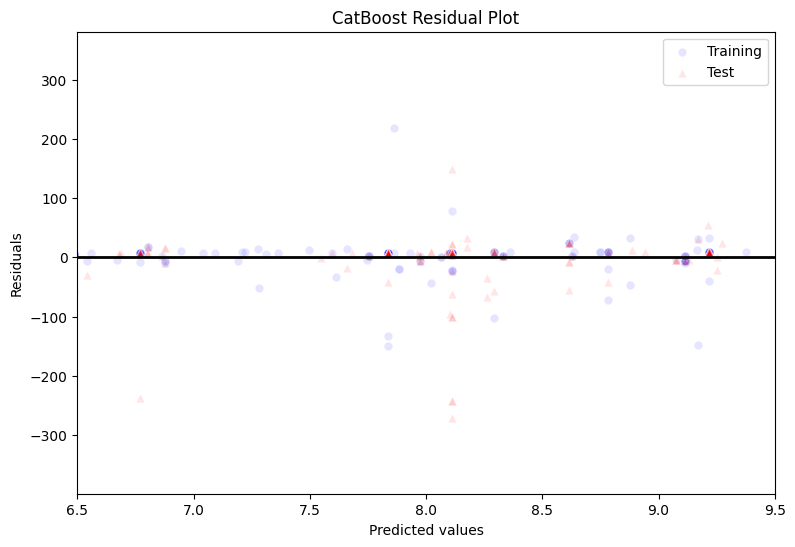

In [64]:
train_preds = cb_reg.predict(X_train)

residual_plot(y_train[:10000], train_preds[:10000], 
              y_val[:10000], val_preds[:10000], 
              title="CatBoost Residual Plot")

In [65]:
feat_importances = cb_reg.get_feature_importance(prettified=True)
feat_importances

,Feature Id,Importances
0,pca_0,4.719913e+01
1,late_start,4.307233e+01
2,task_id_3.15,1.583459e+00
3,task_id_4.7,1.347131e+00
4,obj_prg_Здравоохранение,8.656666e-01
...,...,...
100,task_id_9,1.873698e-06
101,task_id_1.6,4.169383e-07
102,task_id_3.21,1.845584e-35
103,task_id_3.20,0.000000e+00


In [67]:
train_data = Pool(data=X_train, label=y_train)

val_data = Pool(data=X_val, label=y_val)

In [68]:
explainer = shap.TreeExplainer(cb_reg_1) 
shap_values = explainer.shap_values(train_data)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


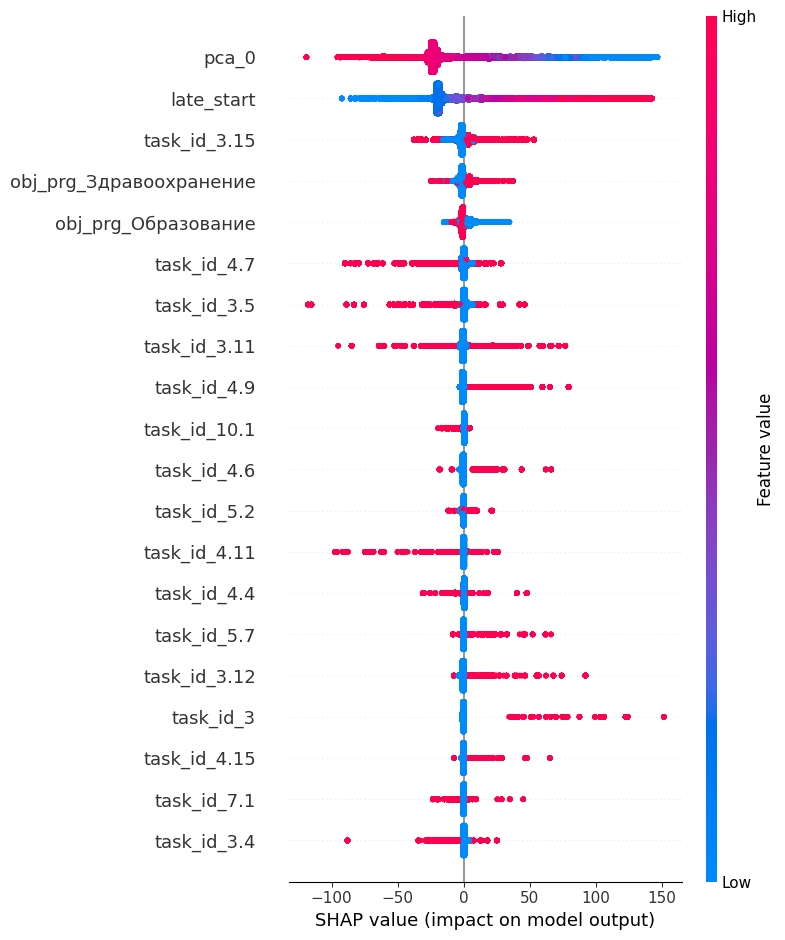

In [69]:
shap.summary_plot(shap_values, X_train)